In [1]:
# ! pip install dask leidenalg

In [2]:
import sys

path_src = '../src'
sys.path.append(path_src)
import importlib
import SpatialAnalysis as SpAn
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import numpy as np
import networkx as nx
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy

path_src = '../../mosna_benchmark/mosna/'
sys.path.append(path_src)
import mosna2 as mosna


Script loaded!
imported


2024-07-19 11:57:14.988550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 11:57:15.108144: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 11:57:15.620739: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/cv2/../../lib64:
202

Script loaded!


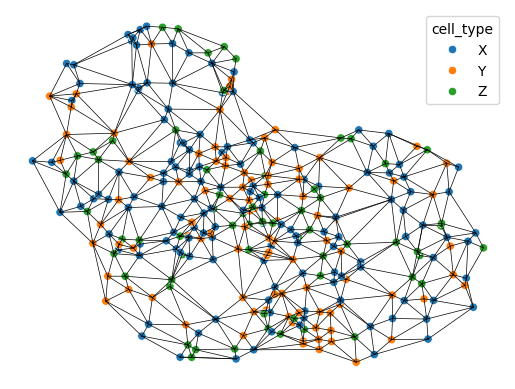

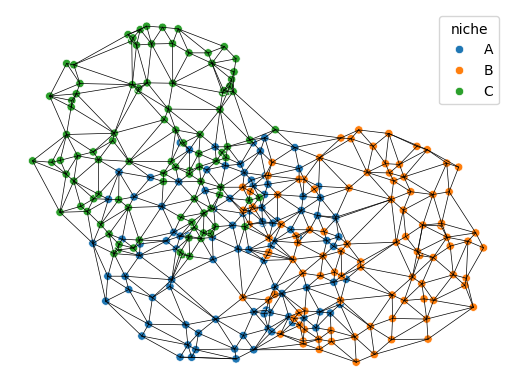

In [30]:
thr = 5
importlib.reload(SpAn)
coords = pd.read_csv('../data/simulation_coordiantes/example_3_niches.csv',sep=',')
points = coords[['x','y']]
types = coords['cell_type']
edges = SpAn.delaunay_edges(points)
edges = SpAn.trim_edges_by_distance(points, edges, thr )
SpAn.plot_network(points, edges, types = types, linewidth = .5)
SpAn.plot_network(points, edges, types = coords['niche'], linewidth = .5)
dum = pd.get_dummies(coords['cell_type']).astype('int')
nodes = pd.concat([coords, dum],axis=1)
nodes['patient'] = '1'
out_path = '../data/simulation_coordiantes/mosna/example_3_niches/net_dir/'
out_dir = out_path + 'nodes_patient-patient.csv'
nodes.to_csv(out_dir, index=False)

# Objective: 
### Reidentify the niches simulated in this dataset:
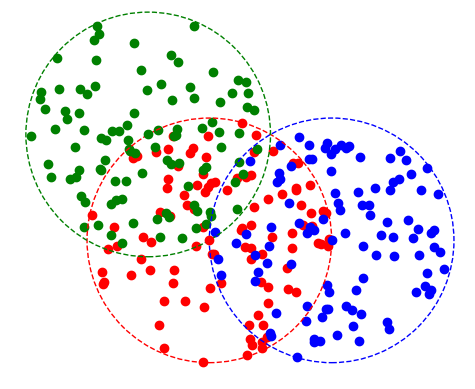

# Mosna

In [54]:
pd.DataFrame(edges).to_csv(out_path + 'edges_patient-patient.csv', index=False)

imported
Loading clusterer object and cluster labels
There are 4 clusters
Loading reducer object and reduced coordinates
embed_viz (300, 2)
select [False False False  True  True  True  True  True False False False False
  True  True  True  True False  True False False False  True  True False
  True  True False False  True  True False  True  True False False  True
  True  True  True False  True False  True False  True False False False
 False False False  True  True  True False  True False  True  True  True
 False  True False  True False  True False False False False  True False
  True  True False False False  True False  True False False  True  True
  True False False False False False False  True  True  True False False
 False False False  True False False False False False False  True  True
 False False False  True False False  True False False False False False
 False False False False False False False False  True False False  True
 False False False  True  True False False False F

<Figure size 3000x3000 with 0 Axes>

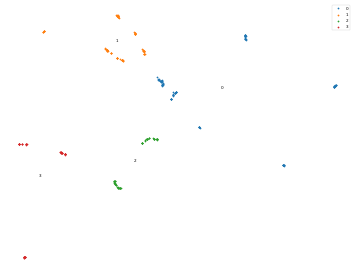

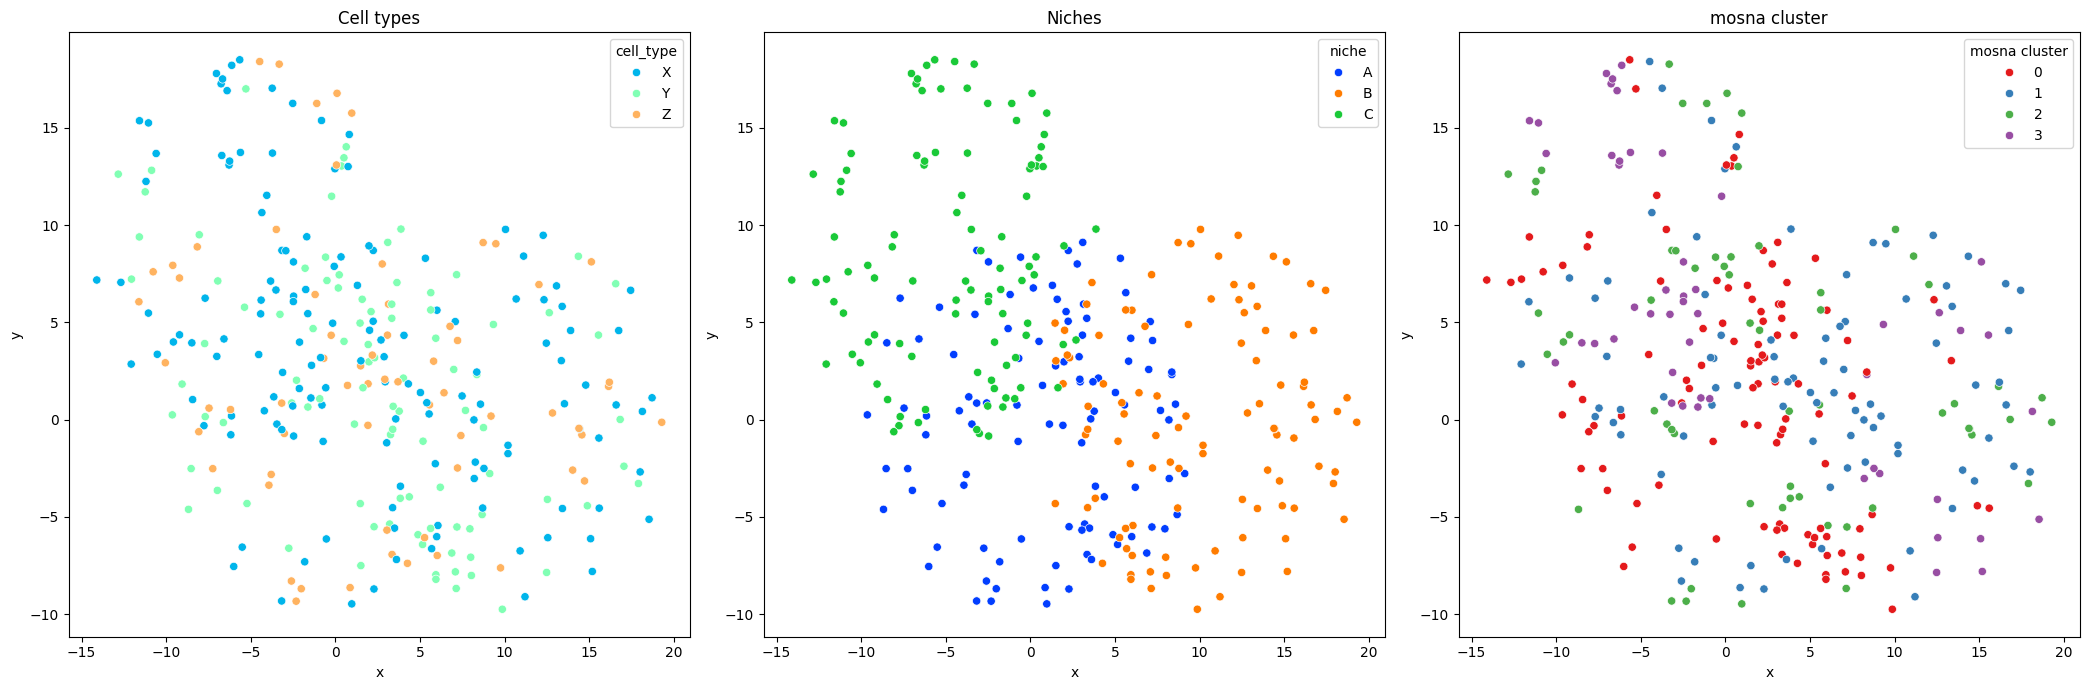

In [51]:
attributes_col = nodes.columns
marker_col = dum.columns

data_info = ['patient']
importlib.reload(mosna)
var_aggreg = mosna.compute_spatial_omic_features_single_network(
    method = 'NAS',
    net_dir = out_path,  
    data_info = data_info,
    extension = 'csv',
    read_fct = pd.read_csv,
    attributes_col=attributes_col, 
    use_attributes=marker_col, # use all attributes 
    make_onehot=False, 
    stat_funcs = 'default', 
    stat_names = 'default', 
    id_level_1='patient',
    save_intermediate_results=False, 
    dir_save_interm=None,
    add_sample_info = False,
    verbose=1,
    )

plt.gcf().set_size_inches(30, 30)

cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 30, 
    'metric': 'cosine', #'manhattan', # or 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 30, 
    'resolution_parameter': 0.005,
}

sof_dir = out_path

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, sof_dir, **cluster_params)

import pathlib
sof_dir = pathlib.Path(sof_dir)

embed_viz, _ = mosna.get_reducer(
    var_aggreg, 
    sof_dir, 
    reducer_type=cluster_params['reducer_type'], 
    n_neighbors=cluster_params['n_neighbors'], 
    metric=cluster_params['metric']
    )

fig, ax, niches_color_mapper = mosna.plot_clusters(
    embed_viz, 
    cluster_labels, 
    sof_dir, 
    cluster_params=cluster_params, 
    figsize=[15,15],
    return_cmap=True,
    )

nodes['mosna cluster'] = cluster_labels

# Create a figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(21, 7))  # 15x5 figure size

# Scatter plot for 'cluster'
sns.scatterplot(data=nodes, x='x', y='y', hue='cell_type', ax=ax[0], palette='rainbow')
ax[0].set_title('Cell types')

# Scatter plot for 'celltype'
sns.scatterplot(data=nodes, x='x', y='y', hue='niche', ax=ax[1], palette='bright')
ax[1].set_title('Niches')

# Scatter plot for 'niche'
sns.scatterplot(data=nodes, x='x', y='y', hue='mosna cluster', ax=ax[2], palette='Set1')
ax[2].set_title('mosna cluster')

# Display the plots
plt.tight_layout()
plt.show()


In [53]:
dum_niches = pd.get_dummies(nodes['niche']).astype('int')
dum_niches.sample()

,A,B,C
70,1,0,0


# UTAG

/tmp/ipykernel_3668560/766260427.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['roi'] = 'ROI1'
/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 300 × 3
    obs: 'x', 'y', 'roi'
    obsm: 'spatial'

Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

Overwriding provided number of PCA dimensions to match number of features: 2


/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
 38%|███▊      | 3/8 [00:00<00:00, 28.42it/s]

Applying Leiden Clustering at Resolution: 1.5...
Applying Leiden Clustering at Resolution: 1...
Applying Leiden Clustering at Resolution: 0.5...
Applying Leiden Clustering at Resolution: 0.3...
Applying Leiden Clustering at Resolution: 0.2...
Applying Leiden Clustering at Resolution: 0.1...


100%|██████████| 8/8 [00:00<00:00, 30.04it/s]


Applying Leiden Clustering at Resolution: 0.05...
Applying Leiden Clustering at Resolution: 0.01...


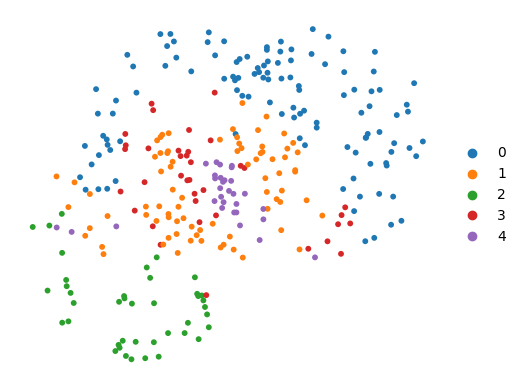

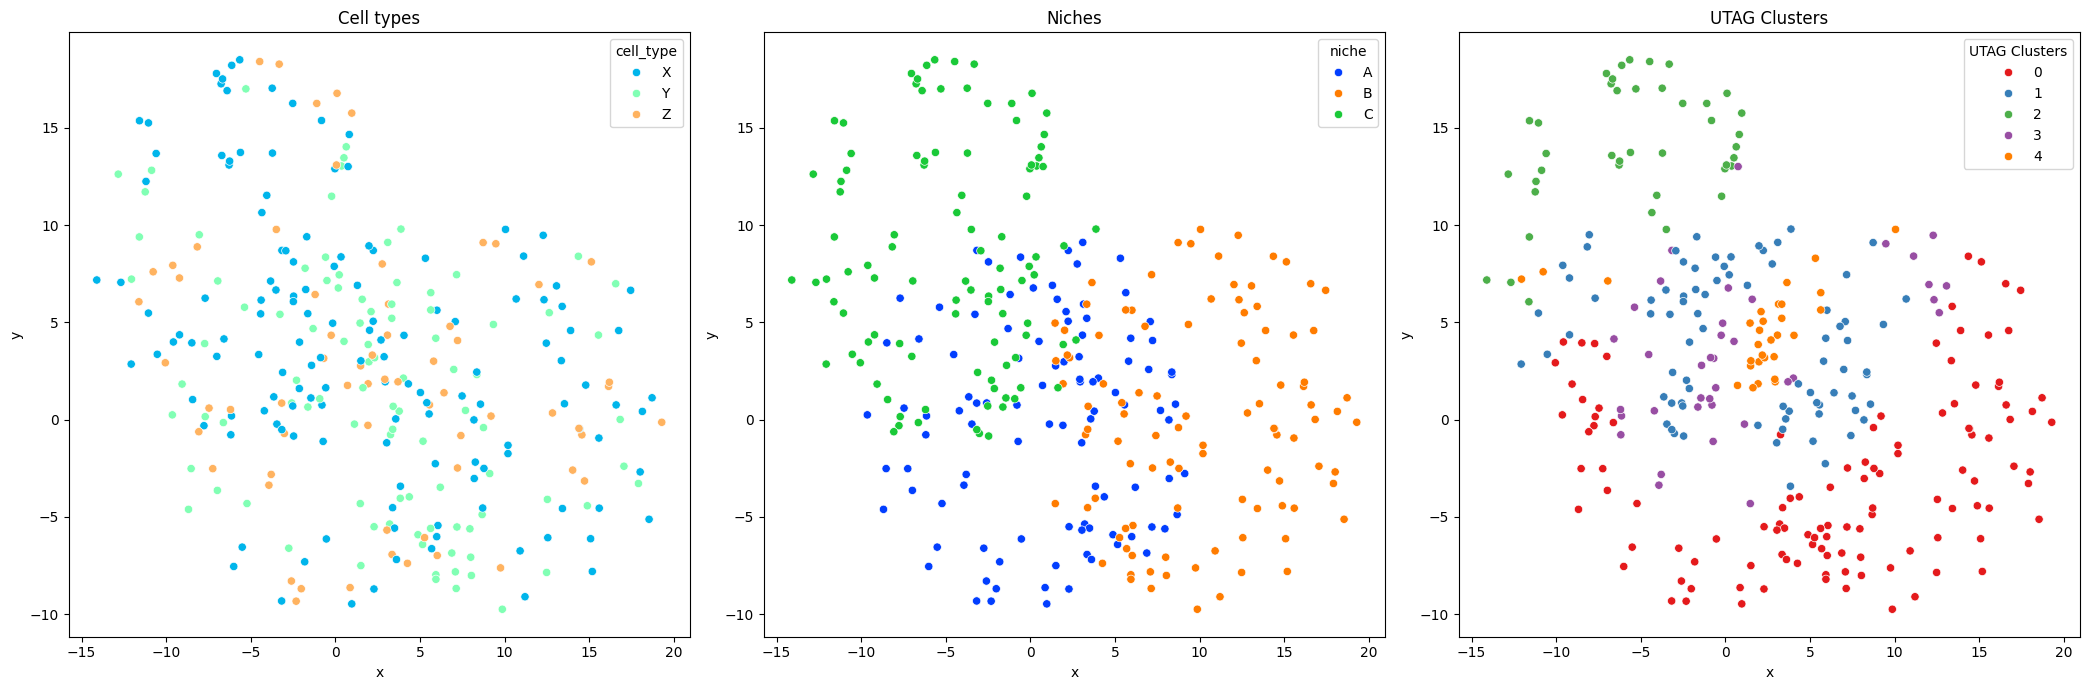

In [55]:
from utag import utag
import scanpy as sc
import squidpy as sq
import anndata
import numpy as np
import matplotlib.pyplot as plt
from anndata import AnnData
import anndata as ad

X = pd.get_dummies(coords['cell_type']).astype(np.float64)

obs = coords[['x', 'y']]
obs['roi'] = 'ROI1'
# Create 'var' dataframe with the one-hot encoded types columns
var = pd.DataFrame(index=X.columns)

# Create AnnData object
minimal_adata = ad.AnnData(X=X.values, obs=obs, var=var)
minimal_adata.obsm['spatial'] = coords[['x', 'y']].values

single_slide = minimal_adata.copy()
display(single_slide)
# Run UTAG on provided data
utag_single_results = utag(
    single_slide,
    slide_key="roi",
    max_dist=20,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions = [1.5,1,.5,.3,.2,.1,.05,.01]
)


sc.pl.spatial(utag_single_results, color = 'UTAG Label_leiden_0.1', spot_size = .5, title = '', frameon = False)


nodes['UTAG Clusters'] = utag_single_results.obs['UTAG Label_leiden_0.2'].values

# Create a figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(21, 7))  # 15x5 figure size

# Scatter plot for 'cluster'
sns.scatterplot(data=nodes, x='x', y='y', hue='cell_type', ax=ax[0], palette='rainbow')
ax[0].set_title('Cell types')

# Scatter plot for 'celltype'
sns.scatterplot(data=nodes, x='x', y='y', hue='niche', ax=ax[1], palette='bright')
ax[1].set_title('Niches')

# Scatter plot for 'niche'
sns.scatterplot(data=nodes, x='x', y='y', hue='UTAG Clusters', ax=ax[2], palette='Set1')
ax[2].set_title('UTAG Clusters')

# Display the plots
plt.tight_layout()
plt.show()


# Cellcharter

In [94]:
import anndata as ad
nodes.sample()

,Unnamed: 0,x,y,niche,cell_type,X,Y,Z,patient
135,135,2.312614,3.177276,B,Y,0,1,0,1


In [95]:
adata = ad.AnnData(X=dum)
adata.obs['niche'] = nodes['niche'].values
adata.obs['cell_type'] = nodes['cell_type'].values
adata.obs['patient'] = nodes['patient'].values
adata.uns['spatial'] = {'coordinates': nodes[['x', 'y']].values.tolist()}
adata.obsm['spatial'] = nodes[['x', 'y']].values
adata

/home/abdelmounim.essabbar/Projects/Spatial-Omics-Networks-Benchmark-/.conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 300 × 3
    obs: 'niche', 'cell_type', 'patient'
    uns: 'spatial'
    obsm: 'spatial'

100%|██████████| 4/4 [00:00<00:00, 1201.89it/s]


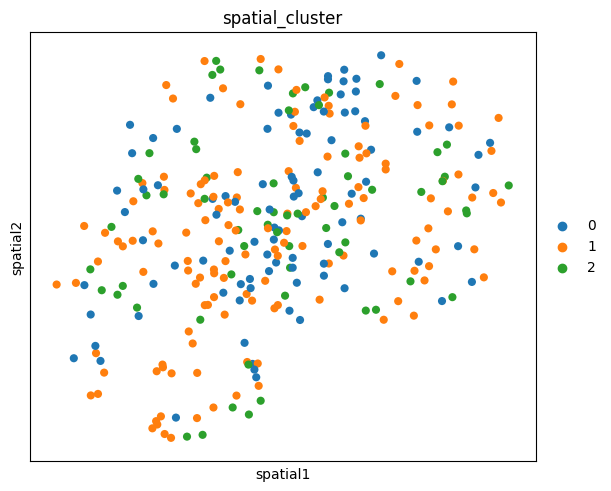

In [102]:
sq.gr.spatial_neighbors(adata, coord_type='generic', delaunay=True)

cc.gr.remove_long_links(adata)

cc.gr.aggregate_neighbors(adata, n_layers=3)
gmm = cc.tl.Cluster(
    n_clusters=3, 
    trainer_params=dict(accelerator='gpu', devices=1)
)
gmm.fit(adata, use_rep='X_cellcharter')
adata.obs['spatial_cluster'] = gmm.predict(adata, use_rep='X_cellcharter')

sq.pl.spatial_scatter(
    adata, 
    color='spatial_cluster', 
    library_key='sample', 
    img=None, 
    size=.3,
    ncols=2,
)


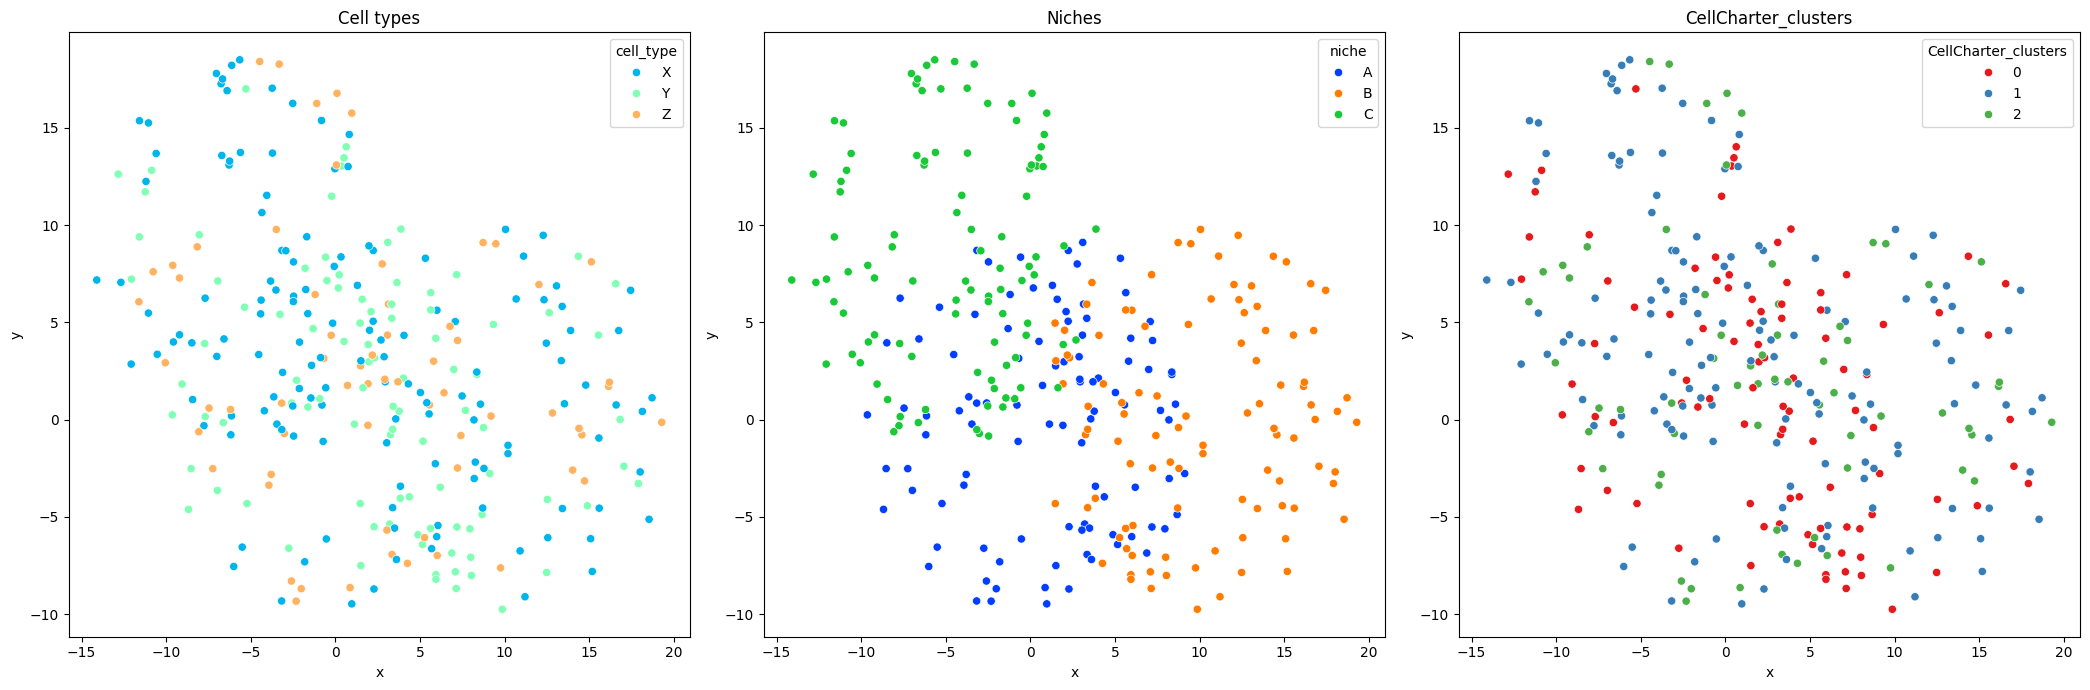

In [105]:
nodes['CellCharter_clusters'] = adata.obs['spatial_cluster'].values

fig, ax = plt.subplots(1, 3, figsize=(21, 7))  # 15x5 figure size

# Scatter plot for 'cluster'
sns.scatterplot(data=nodes, x='x', y='y', hue='cell_type', ax=ax[0], palette='rainbow')
ax[0].set_title('Cell types')

# Scatter plot for 'celltype'
sns.scatterplot(data=nodes, x='x', y='y', hue='niche', ax=ax[1], palette='bright')
ax[1].set_title('Niches')

# Scatter plot for 'niche'
sns.scatterplot(data=nodes, x='x', y='y', hue='CellCharter_clusters', ax=ax[2], palette='Set1')
ax[2].set_title('CellCharter_clusters')

# Display the plots
plt.tight_layout()
plt.show()


# Stagate

In [ ]:
df_markers = dum
df_coords = nodes[['x','y']]

## Create AnnData Object
adata_object = sc.AnnData(df_markers)
adata_object.obsm['spatial'] = df_coords.values
adata_object.obs["cell_type"] = pd.Categorical(nodes['celltype'])

# Perform feature generation and add features to the Anndata object
adata_with_features = SGT.make_features_STARGATE(adata_object)
print(f"Features are made and added to Anndata object for spot {spot}")

# Perform Louvain clustering on the Anndata object
adata_with_louvain_clustering = SGT.clustering_louvain(adata_object)
print(f"Louvain clustering has been performed on Anndata object for spot {spot}")

# Perform niche visualization
print(f"We show the Anndata object prior to niche visualization for spot {spot}")
print(adata_object)
print(adata_object.X)
SGT.niches_visualization(adata_with_louvain_clustering)
print(f"Niche detection has been performed without errors for spot {spot}")

# BayesSpace

#### Check file ```rscript/BayesSpace.R``` for details about running BayesSpace 

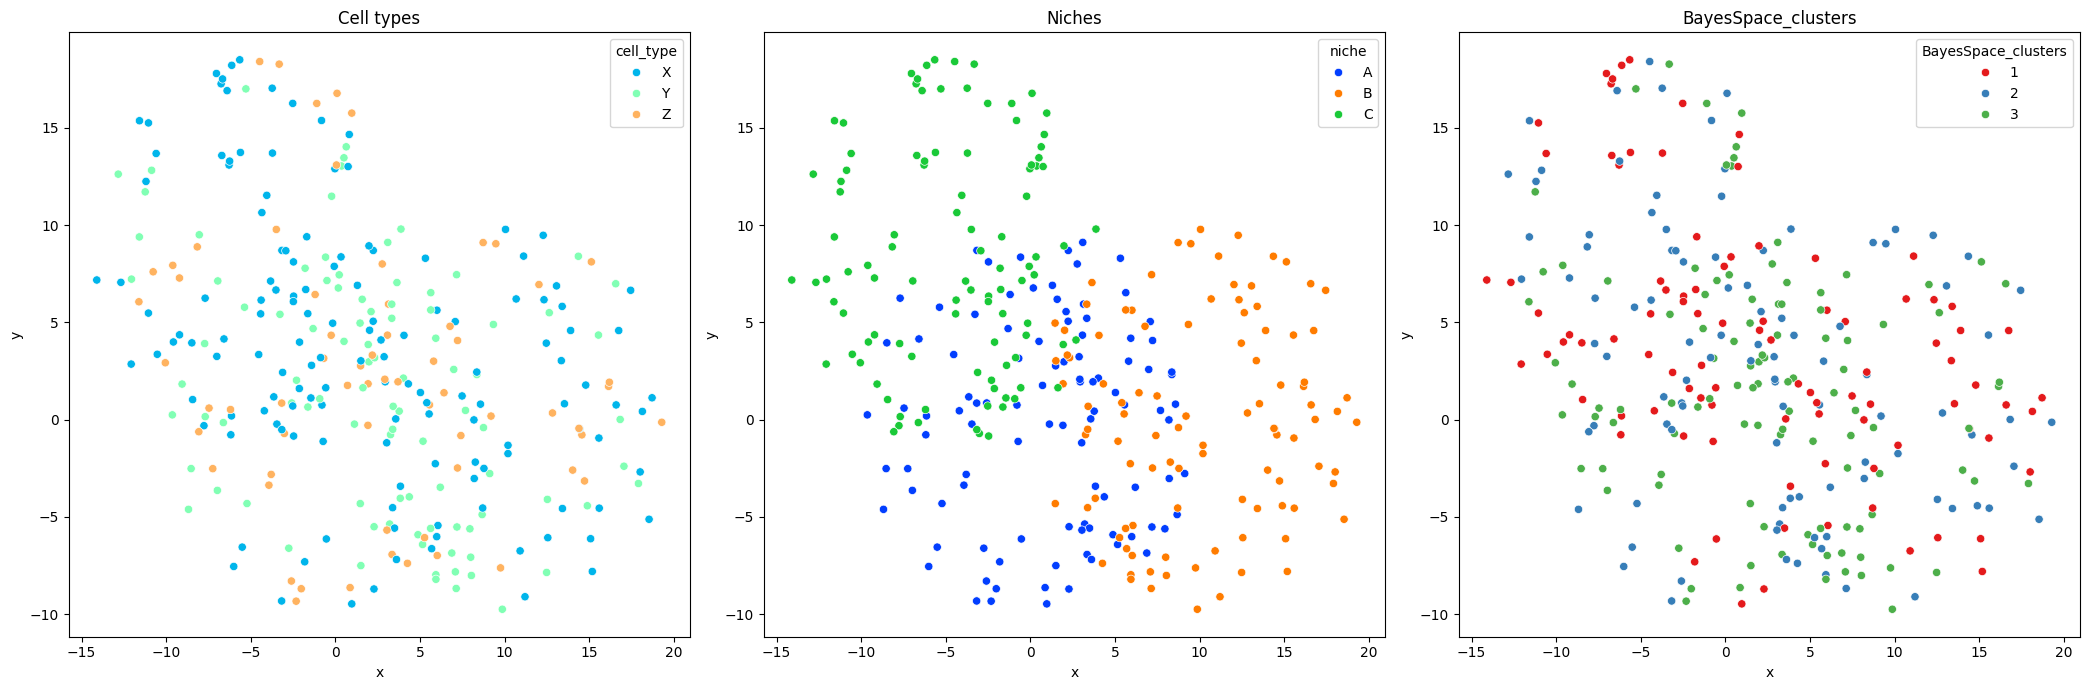

In [19]:
BayesSpace = pd.read_csv('../data/simulation_coordiantes/BayesSpace/example_3.csv', index_col=0)
nodes['BayesSpace_clusters'] = BayesSpace['spatial.cluster'].values

fig, ax = plt.subplots(1, 3, figsize=(21, 7))  # 15x5 figure size

# Scatter plot for 'cluster'
sns.scatterplot(data=nodes, x='x', y='y', hue='cell_type', ax=ax[0], palette='rainbow')
ax[0].set_title('Cell types')

# Scatter plot for 'celltype'
sns.scatterplot(data=nodes, x='x', y='y', hue='niche', ax=ax[1], palette='bright')
ax[1].set_title('Niches')

# Scatter plot for 'niche'
sns.scatterplot(data=nodes, x='x', y='y', hue='BayesSpace_clusters', ax=ax[2], palette='Set1')
ax[2].set_title('BayesSpace_clusters')

# Display the plots
plt.tight_layout()
plt.show()



# SquidPy

In [25]:
nodes.sample()

,Unnamed: 0,x,y,niche,cell_type,X,Y,Z,patient,BayesSpace,BayesSpace_clusters
69,69,-7.471165,0.58821,A,Z,0,0,1,1,3,3


/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


  0%|          | 0/1000 [00:00<?, ?/s]

/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


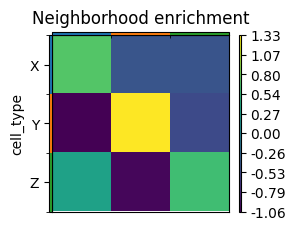

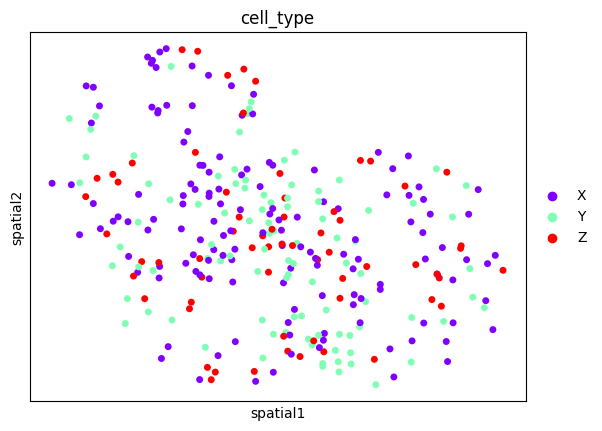

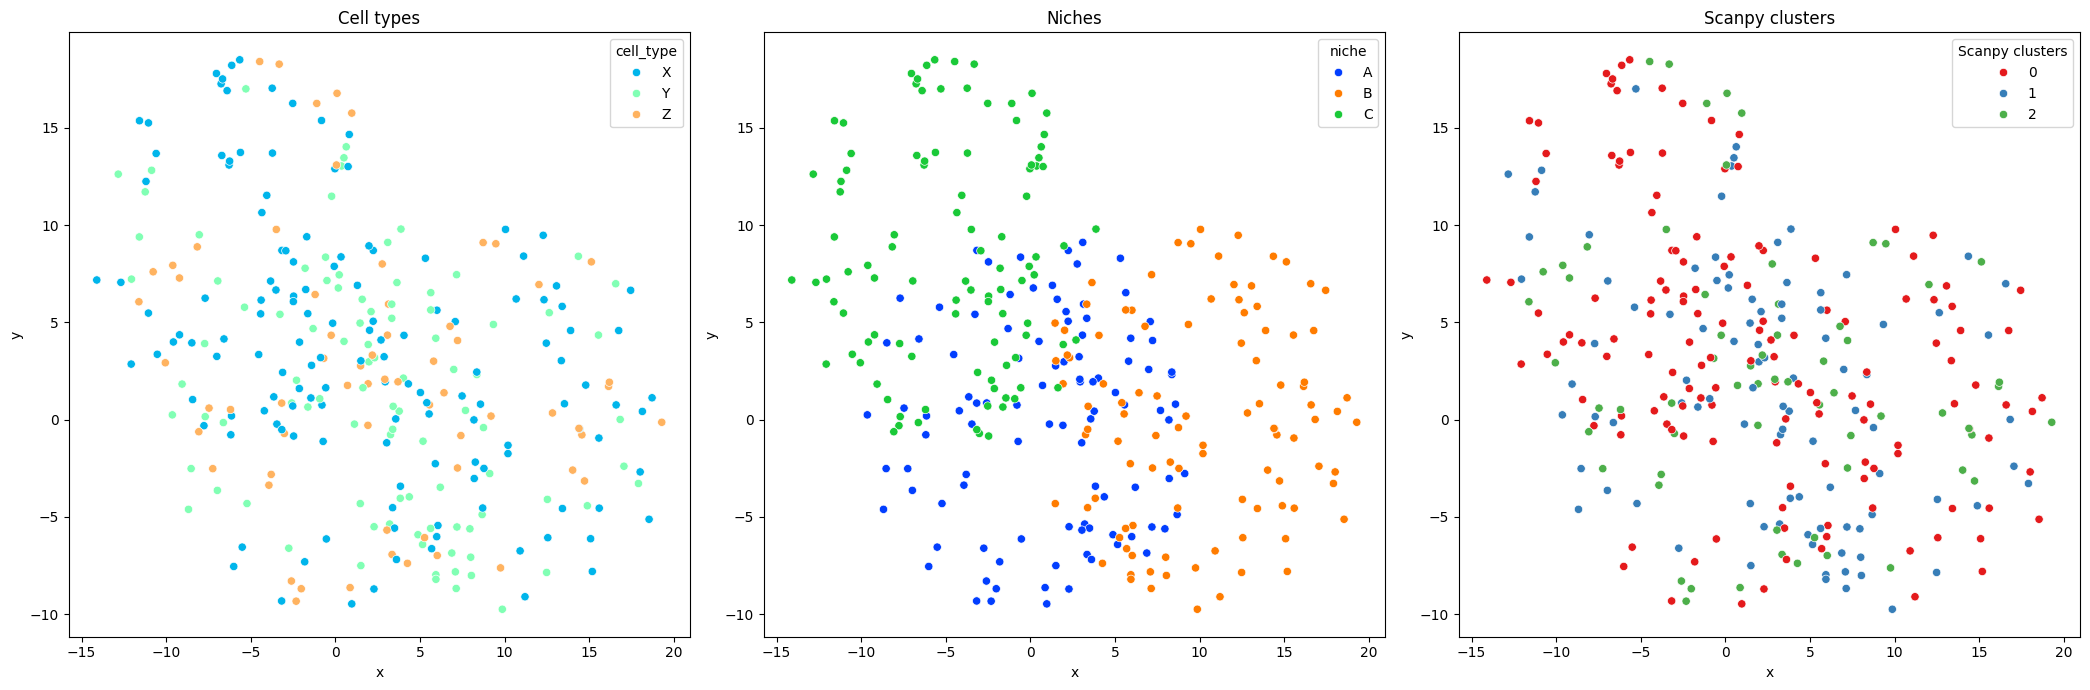

In [80]:
import squidpy as sq
import scanpy as sc
import anndata as ad
import numpy as np

# Assuming `data` is your dataset containing 'coordinates' and 'cell_type'
# Create an AnnData object

adata = ad.AnnData(X=dum)  # Random data, replace with your actual gene expression matrix

adata.obs['cell_type'] = pd.Categorical(nodes['cell_type'])  # Random cell types, replace with actual
adata.obsm['spatial'] = nodes[['x','y']].values  # Random coordinates, replace with actual

# Calculate neighborhood enrichment
sq.gr.spatial_neighbors(adata, coord_type="generic")  # Adjust parameters as needed
sq.gr.nhood_enrichment(adata, cluster_key='cell_type')

# Plot neighborhood enrichment
sq.pl.nhood_enrichment(adata, cluster_key='cell_type')

# Additional visualization to explore the spatial distribution
sc.pl.embedding(adata, basis='spatial', color='cell_type', s=100, palette='rainbow')


sc.pp.neighbors(adata, 20)
# Perform clustering
sc.tl.leiden(adata,  resolution=0.5)

# Add clustering results to the data
adata.obs['clusters'] = adata.obs['leiden']


nodes['Scanpy clusters'] = adata.obs['leiden'].values

fig, ax = plt.subplots(1, 3, figsize=(21, 7))  # 15x5 figure size

# Scatter plot for 'cluster'
sns.scatterplot(data=nodes, x='x', y='y', hue='cell_type', ax=ax[0], palette='rainbow')
ax[0].set_title('Cell types')

# Scatter plot for 'celltype'
sns.scatterplot(data=nodes, x='x', y='y', hue='niche', ax=ax[1], palette='bright')
ax[1].set_title('Niches')

# Scatter plot for 'niche'
sns.scatterplot(data=nodes, x='x', y='y', hue='Scanpy clusters', ax=ax[2], palette='Set1')
ax[2].set_title('Scanpy clusters')

# Display the plots
plt.tight_layout()
plt.show()


# StLearn

In [82]:
coordinates = nodes[['x','y']]

/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


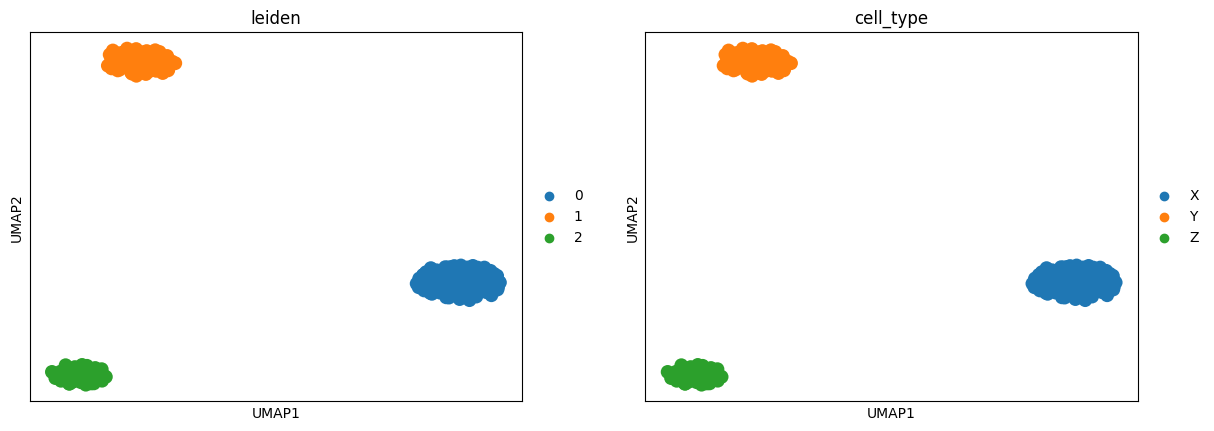

In [87]:
import stlearn as st
import scanpy as sc

# Create an AnnData object
adata = sc.AnnData(X = dum )
adata.obsm['spatial'] = coordinates.values

# Add cell types as metadata
adata.obs['cell_type'] = pd.Categorical(nodes['cell_type'].values)

# Normalize and scale the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

# Neighbors and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

# Visualize the clusters
sc.pl.umap(adata, color=['leiden', 'cell_type'])


# imcRtools

#### Check file ```rscript/imcRtools.R``` for more details 

In [12]:
aN = pd.read_csv('../data/simulation_coordiantes/imcRtools/aggregateNeighbors.csv')
imcRtoolsAN = pd.concat([nodes,aN], axis=1)
imcRtoolsAN.sample()

,Unnamed: 0,x,y,niche,cell_type,X,Y,Z,patient,Unnamed: 0,x,y,coords.x,coords.y,CellType,ImageNb,aggregatedNeighbors.X,aggregatedNeighbors.Y,aggregatedNeighbors.Z,clustered_neighbors
69,69,-7.471165,0.58821,A,Z,0,0,1,1,70,-7.471165,0.58821,-7.471165,0.58821,Z,1,0.4,0.4,0.2,1


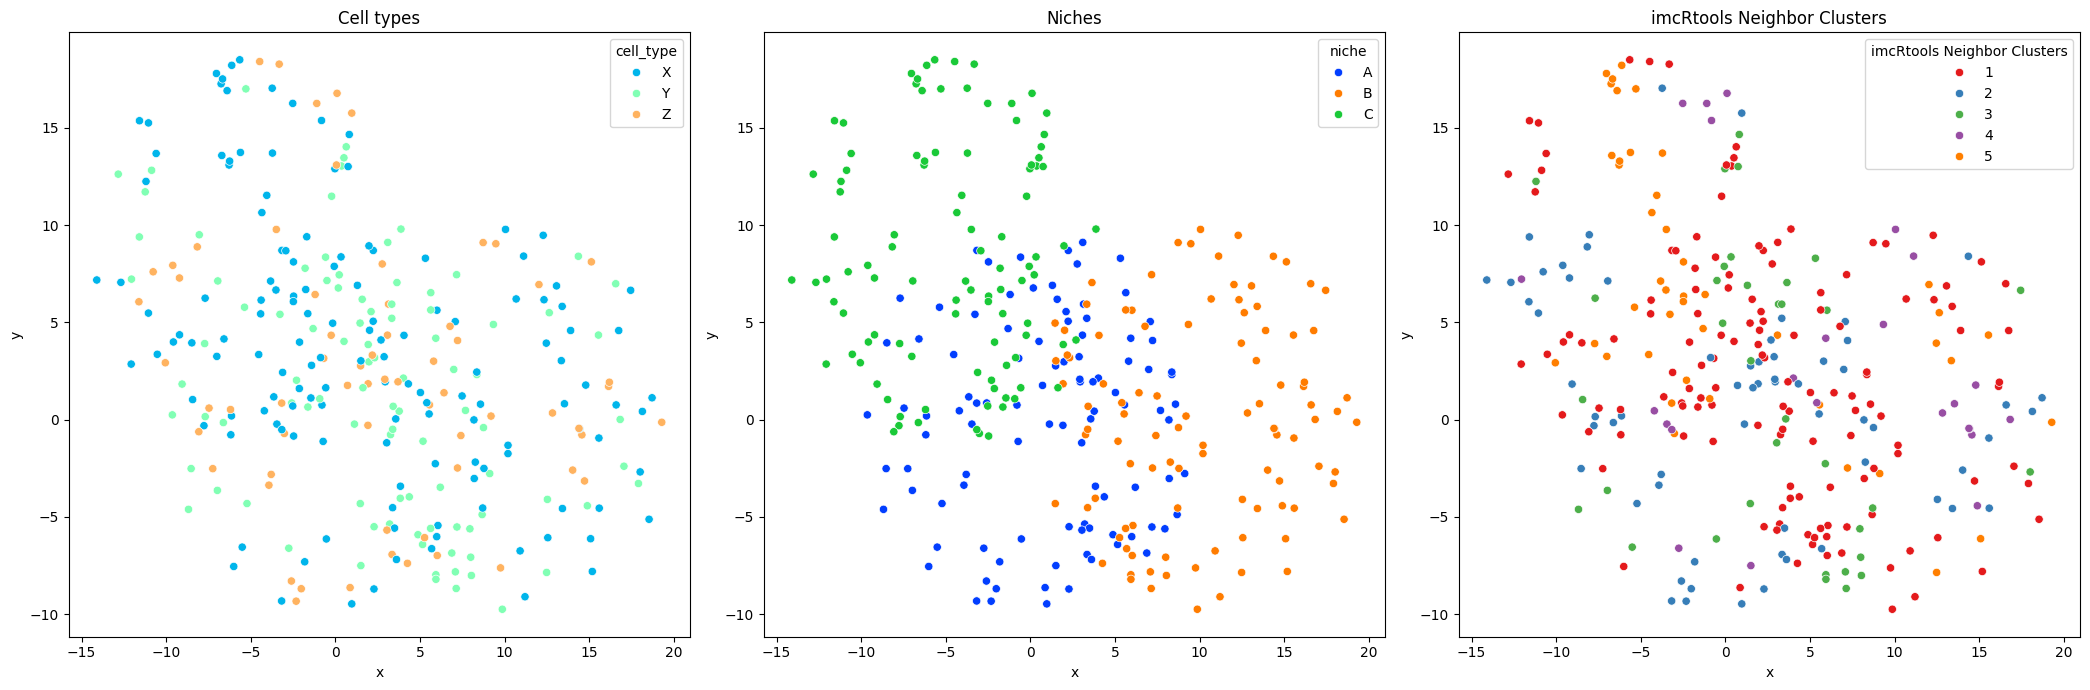

In [13]:

nodes['imcRtools Neighbor Clusters'] = imcRtoolsAN['clustered_neighbors'].values

fig, ax = plt.subplots(1, 3, figsize=(21, 7))  # 15x5 figure size

# Scatter plot for 'cluster'
sns.scatterplot(data=nodes, x='x', y='y', hue='cell_type', ax=ax[0], palette='rainbow')
ax[0].set_title('Cell types')

# Scatter plot for 'celltype'
sns.scatterplot(data=nodes, x='x', y='y', hue='niche', ax=ax[1], palette='bright')
ax[1].set_title('Niches')

# Scatter plot for 'niche'
sns.scatterplot(data=nodes, x='x', y='y', hue='imcRtools Neighbor Clusters', ax=ax[2], palette='Set1')
ax[2].set_title('imcRtools Neighbor Clusters')

# Display the plots
plt.tight_layout()
plt.show()

Script loaded!


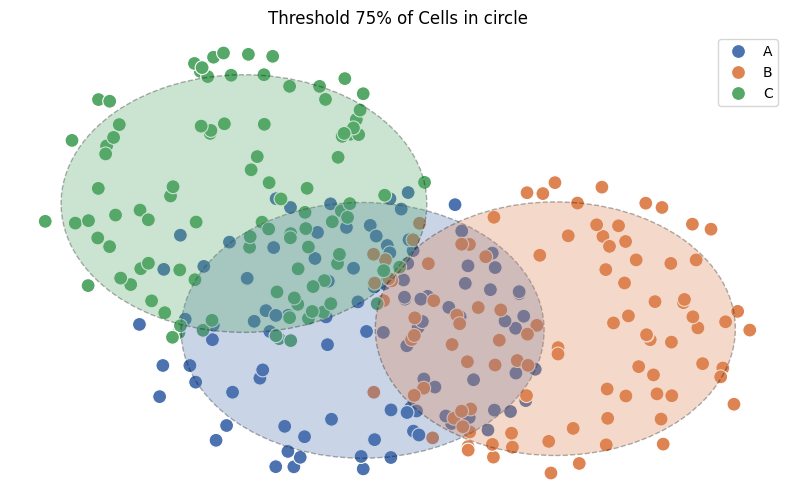

<Axes: title={'center': 'Threshold 75% of Cells in circle'}>

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
importlib.reload(SpAn)

coordinates = pd.DataFrame({'x': nodes['x'], 'y': nodes['y']})
celltypes = pd.Series(nodes['niche'])

SpAn.plot_cells_with_circles(coordinates, celltypes, quantile_threshold=0.75, alpha=0.3)
